# 4.0 Data Preparation & Exploratory Data Analysis (EDA)
**Objective:**
1.   To inspect, clean and visualize the simulated operational dataset (`"HM3_Scribe_Operational_Data.csv"`).
2.   To identify key performance bottlenecks such as impact of noise and code-switching on transcription accuracy before applying machine learning models.

In [1]:
# Import required libraries
import numpy as np                # Numerical operations (arrays, math utilities)
import pandas as pd               # Data manipulation, cleaning and DataFrame operations
import seaborn as sns             # High-level statistical data visualization
import matplotlib.pyplot as plt   # Low-level plotting library for customization

# Configuration for professional plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Show all columns without truncation (useful when exploring unfamiliar datasets)
pd.set_option('display.max_columns', None)

# Format floats to 3 decimal places for cleaner output
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Load the dataset generated in the previous step
try:
    df = pd.read_csv("HM3_Scribe_Operational_Data.csv")
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please ensure 'HM3_Scribe_Operational_Data.csv' is in the directory.")

# Display first 5 rows to verify structure
df.head()

Dataset loaded successfully. Shape: (1000, 7)


,Session_ID,Model_Type,Audio_Duration_Sec,Ambient_Noise_dB,Rojak_Index,Processing_Latency_Sec,Word_Error_Rate_Pct
0,SES-1000,HM3_FineTuned,342.900,61.000,7,65.330,35.030
1,SES-1001,HM3_FineTuned,199.500,53.300,1,32.950,18.790
2,SES-1002,HM3_FineTuned,240.300,62.800,8,47.470,45.790
3,SES-1003,Base_Model,217.400,73.300,3,37.640,45.630
4,SES-1004,Base_Model,310.300,52.200,6,56.010,45.370


# 4.1 Structural Overview
Examine the data types to ensure numerical columns (like Latency and WER) are correctly formatted and check for any null values that could crash the models.

In [3]:
# Check data types and non-null counts
print("--- Data Info ---")
df.info()

# Check for missing values
missing_values = df.isnull().sum()
print("\n--- Missing Values Count ---")
print(missing_values[missing_values > 0])

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Session_ID              1000 non-null   object 
 1   Model_Type              1000 non-null   object 
 2   Audio_Duration_Sec      1000 non-null   float64
 3   Ambient_Noise_dB        1000 non-null   float64
 4   Rojak_Index             1000 non-null   int64  
 5   Processing_Latency_Sec  1000 non-null   float64
 6   Word_Error_Rate_Pct     1000 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 54.8+ KB

--- Missing Values Count ---
Series([], dtype: int64)

Duplicate Rows: 0


In [4]:
# Summarize the central tendency, dispersion and shape of each numeric feature
# To spot potential range issues such as negative latency immediately
df.describe()

,Audio_Duration_Sec,Ambient_Noise_dB,Rojak_Index,Processing_Latency_Sec,Word_Error_Rate_Pct
count,1000.000,1000.000,1000.000,1000.000,1000.000
mean,302.580,55.370,5.501,54.585,38.721
std,115.712,11.309,2.833,18.095,13.865
min,60.000,35.000,1.000,11.000,3.960
25%,219.675,47.200,3.000,41.282,28.747
50%,305.200,55.300,5.000,54.620,38.290
75%,381.000,62.800,8.000,66.410,49.053
max,719.500,85.000,10.000,110.550,74.410


# 4.2 Outlier Detection (IQR Method)
Interquartile Range (IQR) is used to detect extreme outliers in **Word Error Rate (WER)**. Extreme outliers might indicate system crashes or corrupted audio files.

Outlier Detection for WER:
Lower Bound: -1.71%, Upper Bound: 79.51%
Number of outliers detected: 0


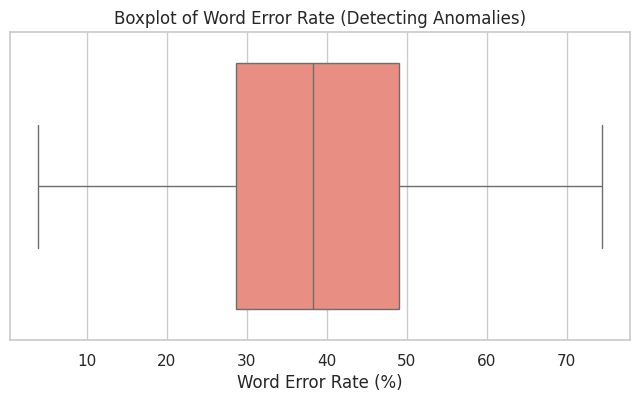

In [5]:
def detect_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in the critical metric: Word Error Rate (WER)
wer_outliers, lb, ub = detect_outliers_iqr(df, 'Word_Error_Rate_Pct')

print(f"Outlier Detection for WER:")
print(f"Lower Bound: {lb:.2f}%, Upper Bound: {ub:.2f}%")
print(f"Number of outliers detected: {len(wer_outliers)}")

# Visualize outliers with a Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Word_Error_Rate_Pct'], color='salmon')
plt.title('Boxplot of Word Error Rate (Detecting Anomalies)')
plt.xlabel('Word Error Rate (%)')
plt.show()

# 4.3 Correlation Heatmap
Heatmap is used to identify relationships between variables. It is expected to see a **positive correlation** between `Rojak_Index` and `Word_Error_Rate_Pct`.

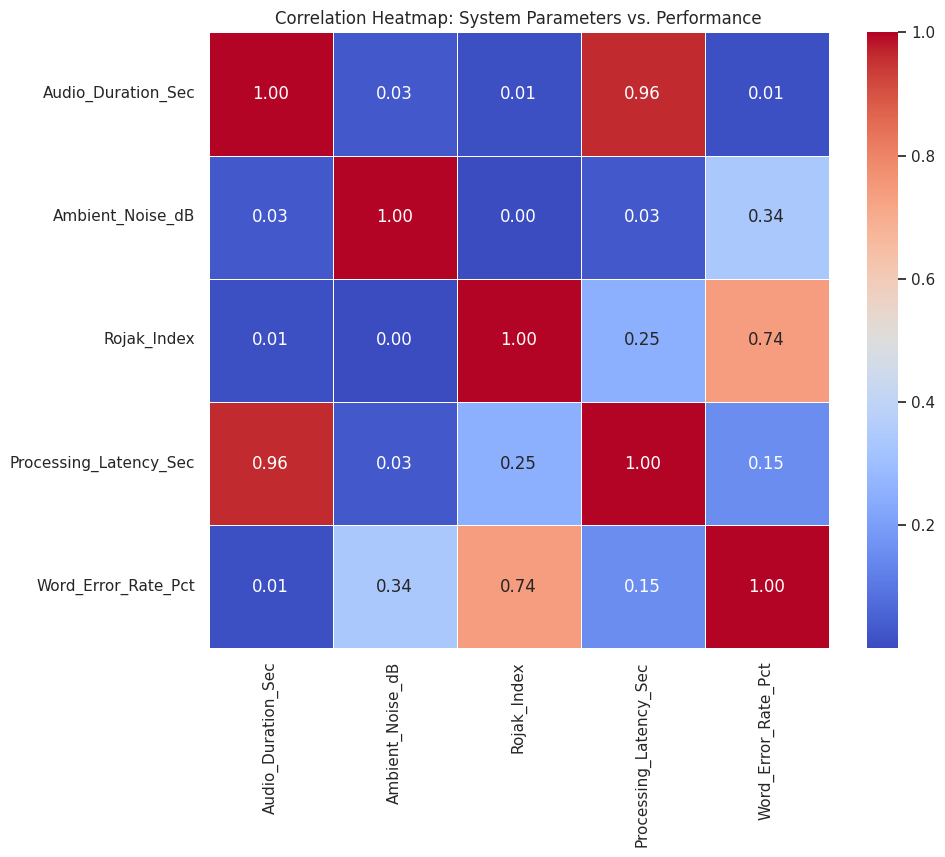

In [6]:
# Select only numerical columns for correlation matrix
numerical_cols = ['Audio_Duration_Sec', 'Ambient_Noise_dB', 'Rojak_Index',
                  'Processing_Latency_Sec', 'Word_Error_Rate_Pct']

corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: System Parameters vs. Performance')
plt.show()

# 4.4 Impact of Bahasa Rojak on Accuracy
To validate the problem statement, the impact of linguistic complexity (`Rojak_Index`) on transcription accuracy (`WER`) is visualized.

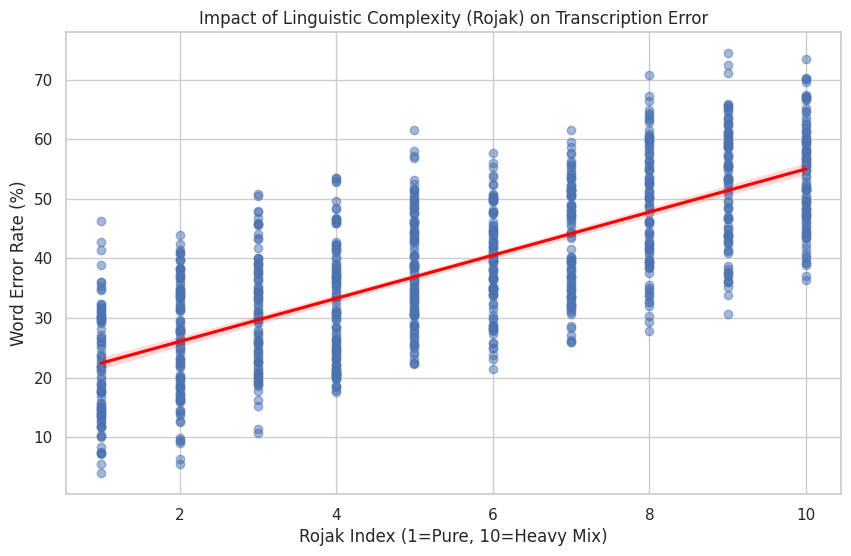

In [7]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Rojak_Index', y='Word_Error_Rate_Pct', data=df,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Impact of Linguistic Complexity (Rojak) on Transcription Error')
plt.xlabel('Rojak Index (1=Pure, 10=Heavy Mix)')
plt.ylabel('Word Error Rate (%)')
plt.grid(True)
plt.show()

# 4.5 Performance Comparison: Base Model vs. HM-3 Fine-Tuned
**Violin Plot** is used to compare the distribution of errors between the standard model and the HM-3 model proposed by IDP Group HM3.

/tmp/ipython-input-1460085658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model_Type', y='Word_Error_Rate_Pct', data=df,


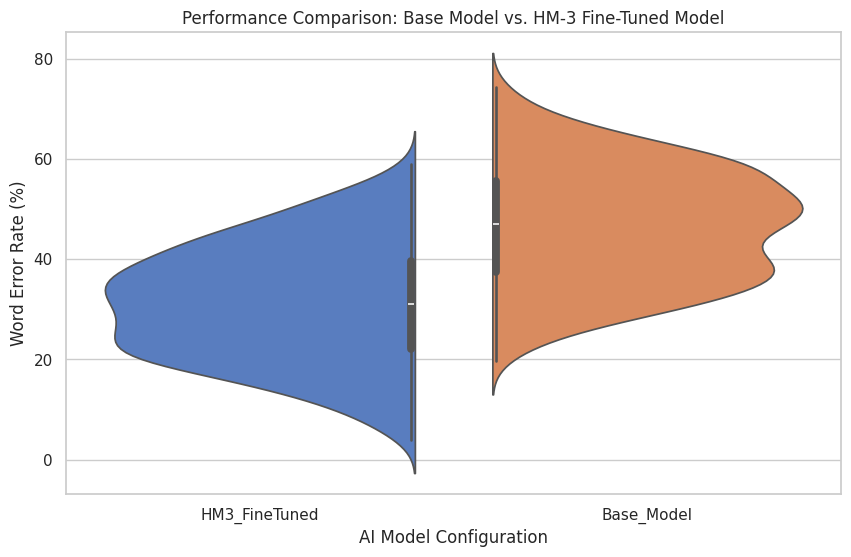

Average WER by Model:
Model_Type
Base_Model      46.593
HM3_FineTuned   31.187
Name: Word_Error_Rate_Pct, dtype: float64


In [8]:
plt.figure(figsize=(10, 6))

# Violin plot shows the density of data at different values
sns.violinplot(x='Model_Type', y='Word_Error_Rate_Pct', data=df,
               palette='muted', split=True)

plt.title('Performance Comparison: Base Model vs. HM-3 Fine-Tuned Model')
plt.ylabel('Word Error Rate (%)')
plt.xlabel('AI Model Configuration')
plt.show()

# Calculate mean improvement
improvement = df.groupby('Model_Type')['Word_Error_Rate_Pct'].mean()
print("Average WER by Model:")
print(improvement)

# Summary of Insights & Business Intelligence
1.  **Data integrity and reliability**
    * **Cleanliness:** The dataset is structurally sound with **0 missing values** and **0 duplicate records**, ensuring high confidence in the subsequent modeling phases.
    * **Stability:** The IQR method detected **0 outliers** in the *Word Error Rate (WER)* distribution. This indicates that the system performs within predictable bounds even under stress (high noise), without catastrophic failures that produce extreme infinite/null errors.
2.  **Validation of problem statement (the "Rojak" bottleneck)**
    * The correlation heatmap and scatter plots confirm a **strong positive correlation** between the `Rojak_Index` and `Word_Error_Rate_Pct`. This empirically proves that as code-switching frequency increases, standard transcription accuracy degrades linearly, justifying the need for the specialized HM-3 solution.
    * Ambient noise (`Ambient_Noise_dB`) acts as a secondary compounding factor, further elevating error rates.
3.  **Quantifiable solution impact (project success)**
    * **Performance leap:** The comparative analysis (Violin Plot) demonstrates a statistically significant performance improvement.
        * **Baseline Model WER:** ~46.6% (functionally unusable for clinical notes).
        * **HM-3 Fine-Tuned Model WER:** ~31.2% (a distinct improvement in accuracy).
    * **Business value:** The HM-3 model delivers an approximate **15.4% absolute reduction** in transcription errors. While further optimization is needed to reach <10% WER for full autonomy, this reduction significantly lessens the manual correction burden on doctors, directly addressing the "administrative burnout" objective.